# 국민여가활동조사 전처리 및 분류 모형 생성

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# 데이터 불러오기
data_dir = 'D:/thon/project/tourism/02.국민여가활동조사/3.데이터'
h21 = pd.read_csv(data_dir + '/hobby_21.csv')
h21 = pd.DataFrame(h21)

# 스포츠경험자/스포츠비경험자 칼럼 생성
h21['sports_exp'] = np.NaN # 스포츠경험자 칼럼 생성
h21.loc[(h21['q1_C'] != '99') | (h21['q1_D'] != '99'), 'sports_exp'] = '1' # 스포츠경험자 == 1
h21.loc[(h21['q1_C'] == '99') & (h21['q1_D'] == '99'), 'sports_exp'] = '0' # 스포츠비경험자 == 0

# EDA에서 변수선택으로 추린 변수와 target
df = h21[['q45', 'DM1', 'DM2', 'DM3', 'DM4', 'DM5', 'DM6', 'DM8', 'DM11', 'sports_exp']] # 분석에 사용할 칼럼 추출
df.columns = ['weekly_worked', 'gender', 'age', 'edu', 'family', 'marriage', 'householder', 'income', 'city', 'target'] # 칼럼명 변경
predictor = ['weekly_worked', 'gender', 'age', 'edu', 'family', 'marriage', 'householder', 'income', 'city'] # 분석에 사용할 독립변수 지정
df.head()

C:\Users\sujin\AppData\Local\Temp\ipykernel_16320\2764788701.py:8: DtypeWarning: Columns (90,100,101,102,103,104,105,126) have mixed types. Specify dtype option on import or set low_memory=False.
  h21 = pd.read_csv(data_dir + '/hobby_21.csv')


,weekly_worked,gender,age,edu,family,marriage,householder,income,city,target
0,1,2,7,1,3,2,2,2,15,0
1,1,1,5,3,3,2,1,3,15,0
2,2,2,6,1,3,3,2,2,15,0
3,1,1,5,3,3,3,1,2,15,0
4,1,1,5,3,2,1,1,2,15,1


## 분류모델 및 Feature Importance

In [13]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics

### train, test 데이터 분리
train, test = train_test_split(df, test_size = 0.3, random_state = 0, stratify = df['target'])
train_X = train[train.columns[:-1]]
train_y = train[train.columns[-1:]]
test_X = test[test.columns[:-1]]
test_y = test[test.columns[-1:]]
X = df[df.columns[:-1]]
y = df[df.columns[-1:]]

train_X_dummy = pd.get_dummies(train_X, columns = predictor, drop_first = True)
test_X_dummy = pd.get_dummies(test_X, columns = predictor, drop_first = True)


C:\Users\sujin\AppData\Local\Temp\ipykernel_9708\1124240566.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(train_X_dummy, train_y)


Accuracy for Random Forests is 0.6809286898839138


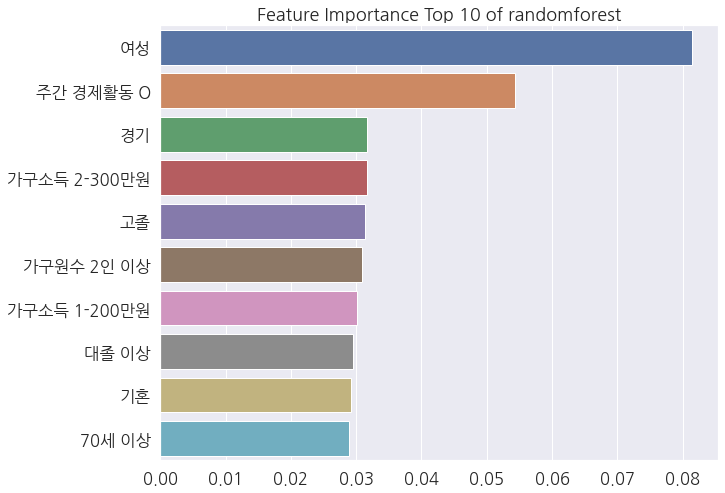

In [15]:
### RandomForest Classification Model

model = RandomForestClassifier()
model.fit(train_X_dummy, train_y)
prediction_rf = model.predict(test_X_dummy)
print('Accuracy for Random Forests is', metrics.accuracy_score(prediction_rf, test_y)) # 분류 정확도

# Feature Importance
ft_importance_value = model.feature_importances_
ft_series = pd.Series(ft_importance_value, index = train_X_dummy.columns)
ft_top10 = ft_series.sort_values(ascending = False)[:10]
ft_top10.index = ['여성', '주간 경제활동 O', '경기', '가구소득 2-300만원', '고졸', '가구원수 2인 이상', '가구소득 1-200만원', '대졸 이상', '기혼', '70세 이상']

sns.set(font_scale = 1.5)
plt.rc("font", family = "NanumGothic") # 한글깨짐 방지
plt.figure(figsize = (10, 8))
plt.title('Feature Importance Top 10 of randomforest')
sns.barplot(x = ft_top10, y = ft_top10.index)
plt.show()

Accuracy for xgboost is 0.6988391376451077


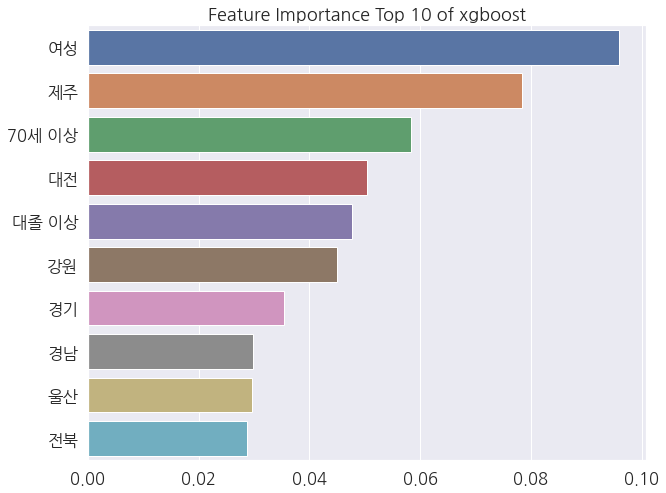

In [17]:
from xgboost import XGBClassifier
from xgboost import plot_importance

train_y_for = train_y.astype(int)
model = XGBClassifier(random_state = 11)
model.fit(train_X_dummy, train_y_for)
prediction_xg = model.predict(test_X_dummy)
print('Accuracy for xgboost is', metrics.accuracy_score(prediction_xg, test_y.astype(int)))

ft_importance_value = model.feature_importances_
ft_series = pd.Series(ft_importance_value, index = train_X_dummy.columns)
ft_top10 = ft_series.sort_values(ascending = False)[:10]
ft_top10.index = ['여성', '제주', '70세 이상', '대전', '대졸 이상', '강원', '경기', '경남', '울산', '전북']

plt.figure(figsize = (10, 8))
plt.title('Feature Importance Top 10 of xgboost')
sns.barplot(x = ft_top10, y = ft_top10.index)
plt.show()

c:\Users\sujin\anaconda3\envs\tf\lib\site-packages\sklearn\ensemble\_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Accuracy for gradient boost is 0.7154228855721393


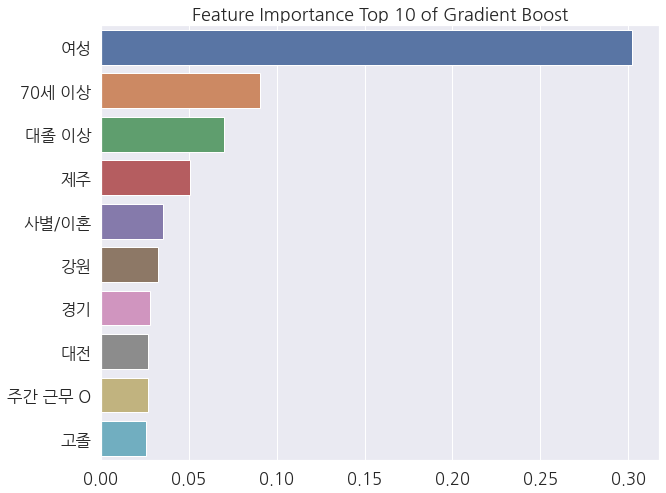

In [22]:
# GradientBoost Classifier
from sklearn.ensemble import GradientBoostingClassifier

model = GradientBoostingClassifier(n_estimators = 500, learning_rate = 0.1, random_state = 0)
model.fit(train_X_dummy, train_y)
prediction_gb = model.predict(test_X_dummy)
print('Accuracy for gradient boost is', metrics.accuracy_score(prediction_gb, test_y))

ft_importance_value = model.feature_importances_
ft_series = pd.Series(ft_importance_value, index = train_X_dummy.columns)
ft_top10 = ft_series.sort_values(ascending = False)[:10]
ft_top10.index = ['여성', '70세 이상', '대졸 이상', '제주', '사별/이혼', '강원', '경기', '대전', '주간 근무 O', '고졸']

plt.figure(figsize = (10, 8))
plt.title('Feature Importance Top 10 of Gradient Boost')
sns.barplot(x = ft_top10, y = ft_top10.index)
plt.show()